In [1]:
# import library 
import pandas as pd 
import pickle
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [2]:
# Define your file path
local_path = os.path.abspath(os.path.join(os.getcwd(), "..", "Dataset"))
file_path = os.path.join(local_path, "chicago_taxi_2023_01.parquet")

# Read the parquet file
chicago_taxi = pd.read_parquet(file_path)

# Show the first few rows
chicago_taxi.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,...,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,pickup_census_tract,dropoff_census_tract
0,97ba079ebea46507a3b4661b3b7ed79db686872c,8c76eb82f069c0731a0049cb78898f02cc5ac6990244c9...,2023-01-31T23:45:00.000,2023-02-01T00:00:00.000,1130,9.67,28,77,25.75,0,...,Cash,Sun Taxi,41.874005383,-87.66351755,"{'coordinates': [-87.6635175498, 41.874005383]...",41.9867118,-87.663416405,"{'coordinates': [-87.6634164054, 41.9867117999...",None,None
1,162af0d8cb5299811f5fc912560104c1fd956459,59b84c0b0d53ada64487e8afa0216f82420ed72f35df5d...,2023-01-31T23:45:00.000,2023-02-01T00:15:00.000,1088,10.21,8,69,27.25,5.55,...,Credit Card,Flash Cab,41.899602111,-87.633308037,"{'coordinates': [-87.6333080367, 41.899602111]...",41.763246799,-87.616134111,"{'coordinates': [-87.6161341112, 41.7632467988...",None,None
2,08651674930f2882922a8ac9811d1de91259e7eb,9f5163473aae222cdf835be350566caf350210ee6a08c0...,2023-01-31T23:45:00.000,2023-02-01T00:00:00.000,1186,17.17,76,28,42,3,...,Credit Card,City Service,41.980264315,-87.913624596,"{'coordinates': [-87.913624596, 41.9802643146]...",41.874005383,-87.66351755,"{'coordinates': [-87.6635175498, 41.874005383]...",None,None
3,ad45519b2fc5c3885786e8cc2396ae9b1d52a6ce,1e17dd9f6bce9b805ec3f6c6b510caa5a64e4b67e9f3b7...,2023-01-31T23:45:00.000,2023-02-01T00:00:00.000,1719,15.1,76,7,39.25,0,...,Cash,City Service,41.980264315,-87.913624596,"{'coordinates': [-87.913624596, 41.9802643146]...",41.922686284,-87.649488729,"{'coordinates': [-87.6494887289, 41.9226862843...",None,None
4,4996c11a492fdeeaf0bcb48ea178ad7fb28042f0,4d383b5d473f9402a59c74dd17d0d1c4d7b2f2c640bd06...,2023-01-31T23:45:00.000,2023-02-01T00:00:00.000,780,0.2,7,22,12.5,0,...,Cash,Taxi Affiliation Services,41.922686284,-87.649488729,"{'coordinates': [-87.6494887289, 41.9226862843...",41.92276062,-87.699155343,"{'coordinates': [-87.6991553432, 41.9227606205...",None,None


In [3]:

chicago_taxi.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414478 entries, 0 to 414477
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   trip_id                     414478 non-null  object
 1   taxi_id                     414478 non-null  object
 2   trip_start_timestamp        414478 non-null  object
 3   trip_end_timestamp          414461 non-null  object
 4   trip_seconds                414378 non-null  object
 5   trip_miles                  414478 non-null  object
 6   pickup_community_area       388824 non-null  object
 7   dropoff_community_area      374445 non-null  object
 8   fare                        414073 non-null  object
 9   tips                        414073 non-null  object
 10  tolls                       414073 non-null  object
 11  extras                      414073 non-null  object
 12  trip_total                  414073 non-null  object
 13  payment_type                4

## Change the data type 

In [4]:
# Convert timestamp columns to datetime
chicago_taxi["trip_start_timestamp"] = pd.to_datetime(chicago_taxi["trip_start_timestamp"], errors="coerce")
chicago_taxi["trip_end_timestamp"] = pd.to_datetime(chicago_taxi["trip_end_timestamp"], errors="coerce")

# Convert trip_seconds to numeric (some values may be missing or malformed)
chicago_taxi["trip_seconds"] = pd.to_numeric(chicago_taxi["trip_seconds"], errors="coerce")

# Create duration in minutes
chicago_taxi["duration_minutes"] = chicago_taxi["trip_seconds"] / 60

In [5]:
print(chicago_taxi[["trip_start_timestamp", "trip_end_timestamp", "duration_minutes"]].head())

  trip_start_timestamp  trip_end_timestamp  duration_minutes
0  2023-01-31 23:45:00 2023-02-01 00:00:00         18.833333
1  2023-01-31 23:45:00 2023-02-01 00:15:00         18.133333
2  2023-01-31 23:45:00 2023-02-01 00:00:00         19.766667
3  2023-01-31 23:45:00 2023-02-01 00:00:00         28.650000
4  2023-01-31 23:45:00 2023-02-01 00:00:00         13.000000


In [6]:
# Count the trip with durations less than or equal to 0
invalid_duration_count = (chicago_taxi["duration_minutes"] <= 0).sum()
print(f"Number of trips with duration_minutes <= 0: {invalid_duration_count}")

Number of trips with duration_minutes <= 0: 7923


In [7]:
# Keep only trips with duration > 0
chicago_taxi = chicago_taxi[chicago_taxi["duration_minutes"] > 0]

## EDA - Feature Importances

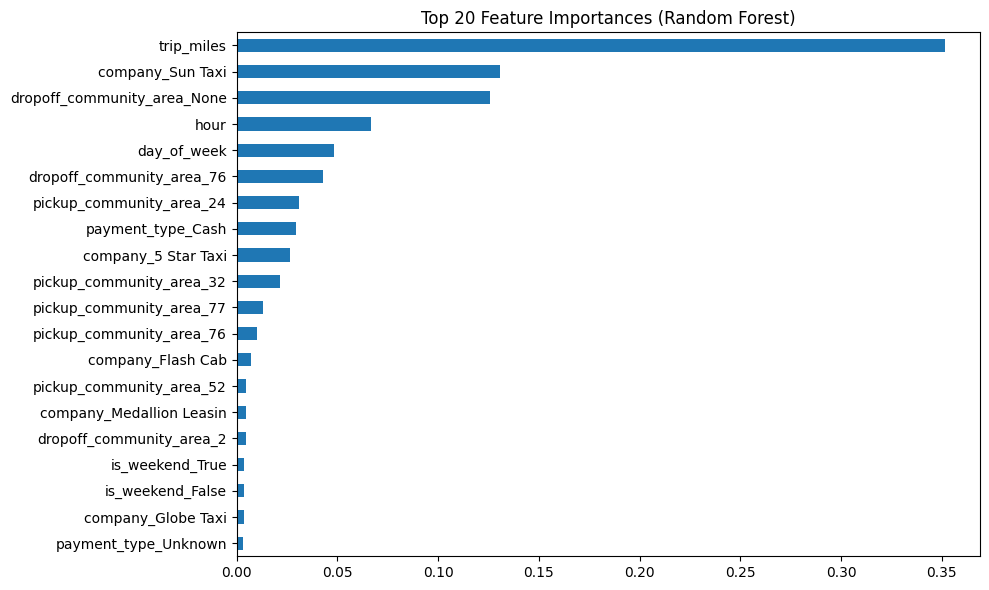

In [8]:
# Assume chicago_taxi is already loaded and preprocessed
df = chicago_taxi.copy()
df = df.sample(n=10000, random_state=42)


# Convert necessary columns to numeric
df["trip_miles"] = pd.to_numeric(df["trip_miles"], errors="coerce")
df["duration_minutes"] = pd.to_numeric(df["duration_minutes"], errors="coerce")

# Drop rows with missing duration or trip_miles
df = df.dropna(subset=["duration_minutes", "trip_miles"])

# Extract time features
df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"], errors="coerce")
df["hour"] = df["trip_start_timestamp"].dt.hour
df["day_of_week"] = df["trip_start_timestamp"].dt.dayofweek
df["is_weekend"] = df["day_of_week"] >= 5

# Select features and target ---
features = [
    "trip_miles", "pickup_community_area", "dropoff_community_area",
    "payment_type", "company", "hour", "day_of_week", "is_weekend"
]
target = "duration_minutes"

X = df[features]
y = df[target]


# Separate numeric and categorical features
numeric_features = ["trip_miles", "hour", "day_of_week"]
categorical_features = ["pickup_community_area", "dropoff_community_area", "payment_type", "company", "is_weekend"]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Full pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=50, n_jobs = -1, random_state=42))
])

# Train/Test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train the model 
model.fit(X_train, y_train)

#  Feature importance 
feature_names = (
    numeric_features +
    list(model.named_steps["preprocessor"]
              .named_transformers_["cat"]
              .named_steps["onehot"]
              .get_feature_names_out(categorical_features))
)

importances = model.named_steps["regressor"].feature_importances_

# Combine and sort
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
feature_importance.head(20).plot(kind='barh')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Shows if missing dropoff info is linked to very short or very long trips.

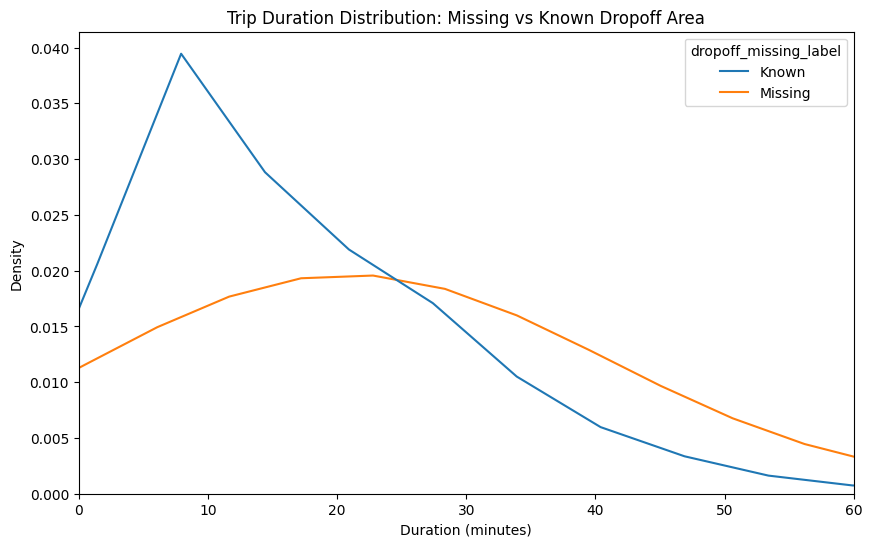

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add label column
df['dropoff_missing_label'] = df['dropoff_community_area'].isna().map({True: 'Missing', False: 'Known'})

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='duration_minutes', hue='dropoff_missing_label', common_norm=False)
plt.xlim(0, 60)
plt.title("Trip Duration Distribution: Missing vs Known Dropoff Area")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.show()  # <- No plt.legend() needed


##### Trips with missing dropoff_community_area tend to be:

Trips with missing dropoff_community_area are more likely to be longer in duration compared to trips with known dropoff areas.



### Trip Duration vs Days of Week

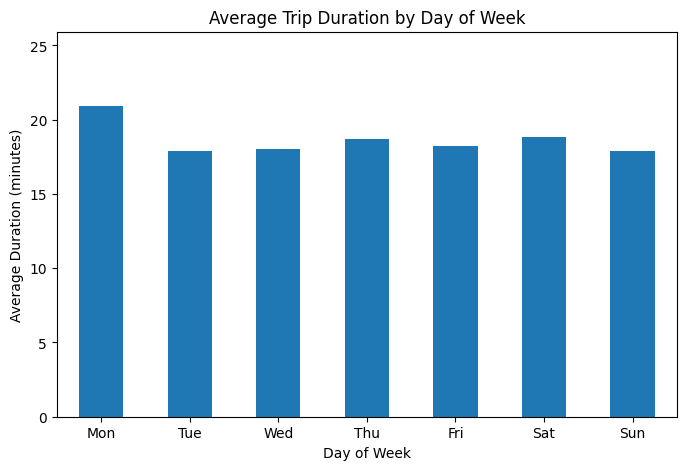

In [10]:
avg_duration_by_day = df.groupby('day_of_week')['duration_minutes'].mean().reindex(range(7))

plt.figure(figsize=(8, 5))
avg_duration_by_day.plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.title("Average Trip Duration by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration (minutes)")
plt.ylim(0, avg_duration_by_day.max() + 5)
plt.show()
